# Import libraries

In [1]:
from IPython.display import Image, clear_output
import os
import shutil
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.image as mpimg
import time
import string
import re

# Download and clean dataset

In [2]:
!gdown --id 1VdicuemXgiHdHute2S6xg2lgHpye4iZB
!unzip VizWiz.zip
!rm VizWiz.zip
clear_output()

In [3]:
def move_all(source_dir, destination_dir, ftype='all'):
    file_names = os.listdir(source_dir)
    types = ['txt', 'png']
    if ftype == 'all':
        for file_name in file_names:
            shutil.move(os.path.join(source_dir, file_name), destination_dir)
        return
    if ftype not in types:
        print(f"File endwith {ftype} doesn't support!")
        return
    for file_name in file_names:
        if file_name.endswith(ftype):
            shutil.move(os.path.join(source_dir, file_name), destination_dir)

Check the quantity of the files in dataset

In [4]:
print("Number of images in the folder", len(os.listdir('/content/img')))
print("Number of labels in the folder", len(os.listdir('/content/txt')))

Number of images in the folder 5018
Number of labels in the folder 5713


Because of the imbalance of its, we need to delete some redundant txt files

In [5]:
source_dir = '/content/txt'
target_dir = '/content/img'
# move all caption files to image folder    
move_all(source_dir, target_dir, 'txt')

In [6]:
print("Number of images in the folder", len(os.listdir('/content/img')))
print("Number of captions in the folder", len(os.listdir('/content/txt')))

Number of images in the folder 10731
Number of captions in the folder 0


In [7]:
target_dir = '/content/img'
file_names = os.listdir(target_dir)
images = []
labels = []    
for idx, file_name in enumerate(file_names):
    if file_name.endswith('txt'):
      name = file_name.split('.')[:-1]
      res = ""
      for tmp in name:
        res = res + tmp + "."
      images.append(res)
    else:
      name = file_name.split('.')[:-1]
      res = ""
      for tmp in name:
        res = res + tmp + "."
      labels.append(res)
print(images)
print(labels)
redundancy = list(set(images) - set(labels))
print(redundancy)

['24111.', '25344.', '27216.', '25636.', '25916.', '30968.', '31165.', '26592.', '27946.', '24295.', '26153.', '25982.', '28790.', '30997.', '30256.', '31068.', '25660.', '25951.', '29827.', '28000.', '24445.', '26264.', '30394.', '25369.', '26327.', '24218.', '23676.', '25265.', '28070.', '28291.', '27478.', '23722.', '25110.', '26098.', '24360.', '27164.', '23861.', '30533.', '26260.', '29712.', '25476.', '23905.', '25300.', '27139.', '23588.', '24419.', '23678.', '26833.', '25912.', '23851.', '30609.', '30374.', '27409.', '27456.', '28150.', '27542.', '23637.', '28691.', '25771.', '28427.', '27430.', '26274.', '30644.', '27292.', '23436.', '23885.', '27239.', '24076.', '28501.', '24543.', '29531.', '30690.', '27309.', '28840.', '25964.', '30234.', '28043.', '28075.', '23598.', '29372.', '24427.', '25221.', '31100.', '24186.', '24161.', '25821.', '27587.', '24823.', '25796.', '30334.', '26883.', '23496.', '26424.', '23581.', '27600.', '30133.', '27446.', '27821.', '26484.', '24733.',

In [8]:
print(len(redundancy))

695


In [9]:
for redundant_file in redundancy:
    os.remove('/content/img/' + redundant_file +'txt')

In [10]:
source_dir = '/content/img'
target_dir = '/content/txt'
# move all label files to image folder    
move_all(source_dir, target_dir, 'txt')

In [11]:
print("Number of images in the folder", len(os.listdir('/content/img')))
print("Number of labels in the folder", len(os.listdir('/content/txt')))

Number of images in the folder 5018
Number of labels in the folder 5018


Now, it's cleaned

# Vector Space Model

In [12]:
# text lowercase
def text_lowercase(text):
    return text.lower()

# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
    
# remove whitespace from text
def remove_whitespace(text):
    return  " ".join(text.split())

In [13]:
current_path = '/content/txt'
corpus = []
id_corpus = []
for file_name in sorted(os.listdir(current_path)):
    """ We don't use utf-8. Use cp1252 instead.
    https://stackoverflow.com/questions/46000191/utf-8-codec-cant-decode-byte-0x92-in-position-18-invalid-start-byte

    If you want to use utf-8, add try-catch exception to avoid decode error
    """
    
    lines = open(os.path.join(current_path, file_name), 'r', encoding='cp1252')
    temp_str = ''
    try:
        for line in lines:
            if line[-1] == '\n': # if last character is endline character
                temp_str += line[:-1] + ' ' # delete endline character
            else:
                temp_str += line
        temp_str = text_lowercase(temp_str)
        temp_str = remove_punctuation(temp_str)
        temp_str = remove_whitespace(temp_str)
        corpus.append(temp_str)
        id_corpus.append(str(file_name[:-4]))
        lines.close()
    except:
        pass

In [14]:
print(len(corpus))
print(len(id_corpus))

5018
5018


In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
#['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
print(X.shape)

['00' '00011420' '0047' ... 'zoomtext' 'zucca' 'zylo']
(5018, 9496)


In [16]:
noisy_words = vectorizer.get_feature_names_out()
noisy_words = noisy_words[:350].tolist()
noisy_words

['00',
 '00011420',
 '0047',
 '0216',
 '025332334497912',
 '02577039',
 '026svdv2158001c5',
 '03',
 '03262014',
 '039',
 '042513',
 '0449',
 '04702582be',
 '0518',
 '06',
 '07',
 '07252011',
 '07e536yf11717',
 '0800828282',
 '09',
 '0946',
 '0g',
 '10',
 '100',
 '10001',
 '100180',
 '100312',
 '100g',
 '100p',
 '100s',
 '101',
 '1024',
 '103',
 '103012',
 '104',
 '105',
 '1056',
 '107',
 '109',
 '1098e',
 '1099',
 '10g',
 '10mg',
 '11',
 '1101',
 '1111',
 '111111',
 '1150',
 '11543',
 '11612',
 '11th',
 '12',
 '120',
 '1209pm',
 '121',
 '1218',
 '12289',
 '12291',
 '123111',
 '125',
 '128',
 '129',
 '12ounce',
 '12pack',
 '12pm',
 '12pm3pm',
 '13',
 '130',
 '130x16',
 '14',
 '1402',
 '145',
 '1475',
 '14g',
 '14th',
 '15',
 '150',
 '1503c',
 '150g',
 '1520',
 '1545',
 '15g',
 '15piece',
 '16',
 '160',
 '160gb',
 '1621',
 '165',
 '167',
 '16gb',
 '17',
 '175',
 '17inch',
 '18',
 '180',
 '1813',
 '18431',
 '185',
 '1863',
 '18663603226',
 '1878',
 '18g',
 '19',
 '190',
 '191211',
 '1940s

In [17]:
print(type(noisy_words))

<class 'list'>


In [18]:
#Vector Space representation
import pandas as pd
vector = X
df1 = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
df1

,00,00011420,0047,0216,025332334497912,02577039,026svdv2158001c5,03,03262014,039,042513,0449,04702582be,0518,06,07,07252011,07e536yf11717,0800828282,09,0946,0g,10,100,10001,100180,100312,100g,100p,100s,101,1024,103,103012,104,105,1056,107,109,1098e,...,yourself,youtube,youve,ysl,yves,z3xwcvy78914,z8c6,zaditor,zatarains,zbigniew,zealand,zebra,zebrastriped,zello,zero,zesty,zhu,zinc,zinger,zip,ziploc,ziplock,zipper,zippered,zippers,ziptop,ziti,zln,zodiac,zoe,zofia,zoldem,zolpidem,zone,zoo,zoom,zoomed,zoomtext,zucca,zylo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236579,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [19]:
#loading basic packages
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
print(stopwords.words('english'))
stop_words = set(stopwords.words('english') + noisy_words)
print(stop_words)
print(len(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
# this function returns a list of tokenized and stemmed words of any text
def get_tokenized_list(doc_text):
    tokens = nltk.word_tokenize(doc_text)
    return tokens

# This function will performing stemming on tokenized words
def word_stemmer(token_list):
    ps = nltk.stem.PorterStemmer()
    stemmed = []
    for words in token_list:
        stemmed.append(ps.stem(words))
    return stemmed

In [22]:
# Function to remove stopwords from tokenized word list
def remove_stopwords(doc_text):
  cleaned_text = []
  for words in doc_text:
        if words not in stop_words:
            cleaned_text.append(words)
  return cleaned_text

In [23]:
#Check for single document
tokens = get_tokenized_list(corpus[1])
print("WORD TOKENS:")
print(tokens)
doc_text = remove_stopwords(tokens)
print("\nAFTER REMOVING STOPWORDS:")
print(doc_text)
print("\nAFTER PERFORMING THE WORD STEMMING::")
doc_text = word_stemmer(doc_text)
doc_text

WORD TOKENS:
['a', 'person', 'is', 'holding', 'a', 'bottle', 'that', 'has', 'medicine', 'for', 'the', 'night', 'time', 'a', 'bottle', 'of', 'medication', 'has', 'a', 'white', 'twist', 'top', 'night', 'time', 'medication', 'bottle', 'being', 'held', 'by', 'someone', 'a', 'person', 'holding', 'a', 'small', 'black', 'bottle', 'of', 'night', 'time', 'a', 'bottle', 'of', 'what', 'appears', 'to', 'be', 'cough', 'syrup', 'held', 'in', 'hand']

AFTER REMOVING STOPWORDS:
['person', 'holding', 'bottle', 'medicine', 'night', 'time', 'bottle', 'medication', 'white', 'twist', 'top', 'night', 'time', 'medication', 'bottle', 'held', 'someone', 'person', 'holding', 'small', 'black', 'bottle', 'night', 'time', 'bottle', 'appears', 'cough', 'syrup', 'held', 'hand']

AFTER PERFORMING THE WORD STEMMING::


['person',
 'hold',
 'bottl',
 'medicin',
 'night',
 'time',
 'bottl',
 'medic',
 'white',
 'twist',
 'top',
 'night',
 'time',
 'medic',
 'bottl',
 'held',
 'someon',
 'person',
 'hold',
 'small',
 'black',
 'bottl',
 'night',
 'time',
 'bottl',
 'appear',
 'cough',
 'syrup',
 'held',
 'hand']

In [24]:
doc_ = ' '.join(doc_text)
doc_

'person hold bottl medicin night time bottl medic white twist top night time medic bottl held someon person hold small black bottl night time bottl appear cough syrup held hand'

In [25]:
cleaned_corpus = []
for doc in corpus:
    tokens = get_tokenized_list(doc)
    doc_text = remove_stopwords(tokens)
    doc_text  = word_stemmer(doc_text)
    doc_text = ' '.join(doc_text)
    cleaned_corpus.append(doc_text)
cleaned_corpus

['comput screen show repair prompt screen comput screen repair automat pop partial comput screen show need repair part comput monitor show comput repair messag top laptop blue background dark blue text',
 'person hold bottl medicin night time bottl medic white twist top night time medic bottl held someon person hold small black bottl night time bottl appear cough syrup held hand',
 'white paper show imag black brown dog librari book pictur two dog cover wooden tabl book black tan dog walk snowi street book cover show two dog snow book cover titl dog year imag black brown dog walk street left side due date sticker librari',
 'white box left blue box wooden tabl small rectangular red white box next small rectangular blue box wooden surfac two box medicin one white red blue sit tabl two box appear contain medic eye drop two box pharmaceut product left tabl',
 'close comput monitor power monitor messag display pictur screenshot show error messag app comput screen display error say display 

In [26]:
vectorizerX = TfidfVectorizer()
vectorizerX.fit(cleaned_corpus)
doc_vector = vectorizerX.transform(cleaned_corpus)
print(vectorizerX.get_feature_names_out())

print(doc_vector.shape)

['aadvantag' 'ab' 'abandon' ... 'zoomtext' 'zucca' 'zylo']
(5018, 6790)


In [27]:
df1 = pd.DataFrame(doc_vector.toarray(), columns=vectorizerX.get_feature_names_out())
df1

,aadvantag,ab,abandon,abba,abbott,abiot,abl,abraham,abstract,ac,academi,acai,acceler,accent,accept,access,accessori,accompani,accord,account,accur,acdc,ace,acer,acetaminophen,acid,acidophil,acl15a,acn,acoust,acquir,acquisit,acronym,across,acryl,acryliqu,act,action,activ,activa,...,york,youcam,young,your,youtub,youv,ysl,yve,z3xwcvy78914,z8c6,zaditor,zatarain,zbigniew,zealand,zebra,zebrastrip,zello,zero,zesti,zhu,zinc,zinger,zip,ziploc,ziplock,zipper,ziptop,ziti,zln,zodiac,zoe,zofia,zoldem,zolpidem,zone,zoo,zoom,zoomtext,zucca,zylo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.241519,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Calculate Cosine Similarty
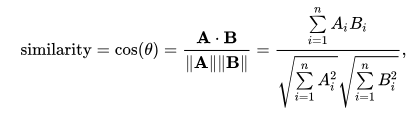

In [28]:
def text_query(query, k=10):

    start = time.time()

    query = text_lowercase(query)
    query = remove_punctuation(query)
    query = remove_whitespace(query)
    query = get_tokenized_list(query)
    query = remove_stopwords(query)
    q = []
    for w in word_stemmer(query):
        q.append(w)
    q = ' '.join(q)
    print('Query steamed: ', q)
    query_vector = vectorizerX.transform([q])

    # calculate cosine similarities
    cosineSimilarities = cosine_similarity(doc_vector,query_vector).flatten()

    related_docs_indices = cosineSimilarities.argsort()[:-(k+1):-1]
    # print((related_docs_indices))
    # for i in related_docs_indices:
    #     data = [cleaned_corpus[i]]
    #     print(data)

    stop = time.time()
    print('Running Time: ', stop - start) 


    fig = plt.figure(figsize=(15, 6))
    for idx, id in enumerate(related_docs_indices):
        img_name = str(id_corpus[id]) + '.png'
        # print(img_name)
        # print(os.path.join('/content/img/', img_name))
        img = mpimg.imread(os.path.join('/content/img/', img_name))
        # cv2_imshow(img)
        fig.add_subplot(2, 5, idx+1)
        plt.title("Top #{}".format(idx+1))
        plt.imshow(img)
        plt.axis('off')

# Querying

Query steamed:  monitor messag display
Running Time:  0.010200977325439453


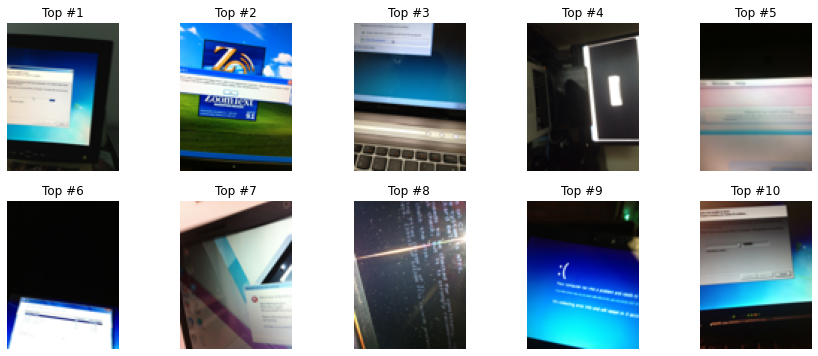

In [29]:
query = 'A monitor has a message displayed on it'
text_query(query)

Query steamed:  keyboard tabl
Running Time:  0.010762929916381836


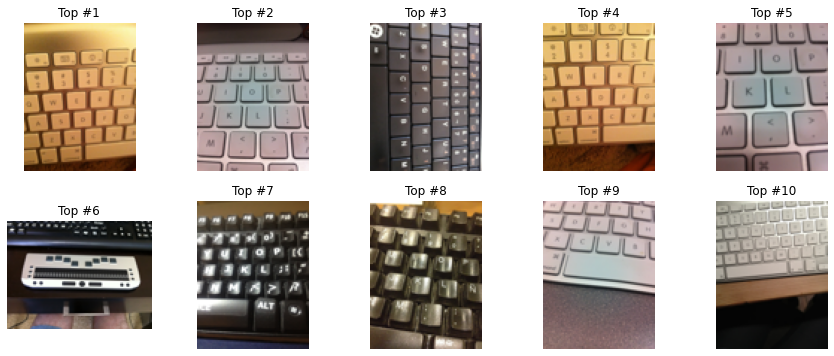

In [30]:
query = 'A keyboard on the table'
text_query(query)

Query steamed:  food menu imag drink food
Running Time:  0.01396942138671875


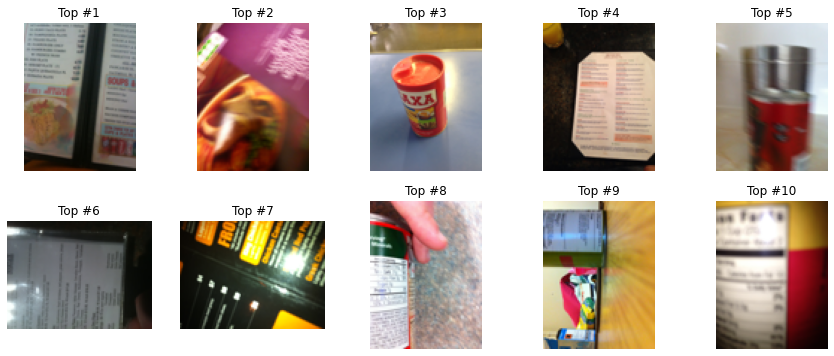

In [37]:
query = 'A food menu with images of drink and food.'
text_query(query)

Query steamed:  pepsi bottl mani color
Running Time:  0.012684106826782227


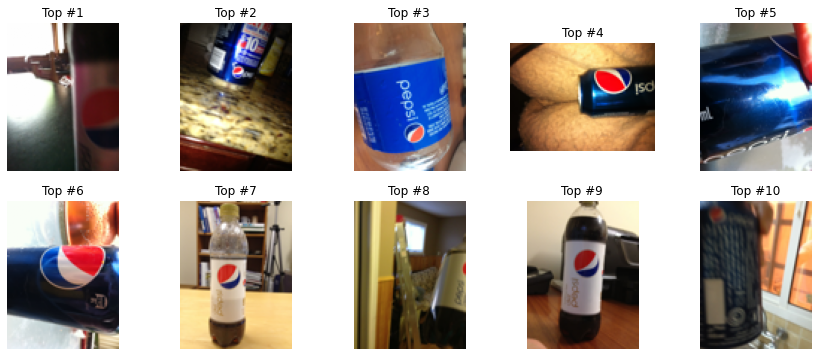

In [36]:
query = 'a PePSi bottlE with many colors'
text_query(query)

Query steamed:  anyth coca cola bottl
Running Time:  0.007535457611083984


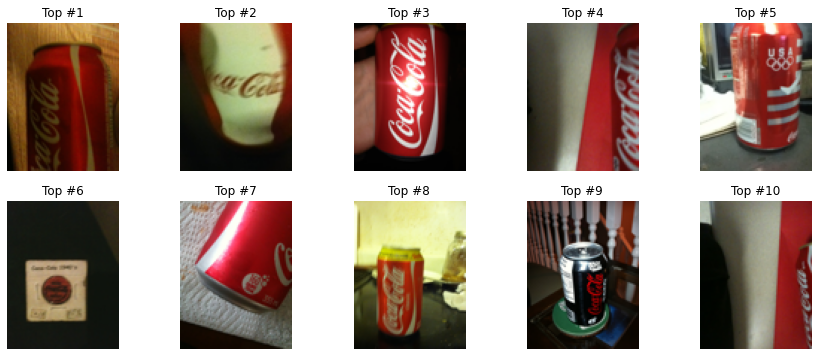

In [42]:
query = 'Anything about Coca cola bottle '
text_query(query)